# Matlantis-features: MDの発展的な使い方
**Contents**

* [0. 基本的な使い方](#advanced_0)
* [1. 乱数シードの固定方法](#advanced_1)
* [2. MD extensionsの使い方](#advanced_2)
* [3. 独自に定義したMD extensionの使い方](#advanced_3)
* [4. NPT integratorの使い方](#advanced_4)
* [5. check point fileからの計算再開方法](#advanced_5)
* [6. MD integratorを構築する方法](#advanced_6)

<a id='advanced_0'></a>
## 0. 基本的な使い方
### 初期化
* 必要なライブラリを準備します。

In [1]:
# If you have already installed matlantis-features, you can skip this.
# Version 0.8.1 or later is required to run this notebook.
!pip install 'matlantis-features>=0.8.1'

Looking in indexes: https://pypi.org/simple, http://pypi.artifact.svc:8080/simple
  Using cached matlantis_features-0.25.2-py3-none-any.whl
  Using cached rdkit-2024.9.4-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (4.0 kB)
  Using cached mock-5.2.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached pfp_api_client-1.23.1-py3-none-any.whl
  Using cached seekpath-2.0.1-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached http://pypi.artifact.svc:8080/simple/reactionstring/0.5.5/reactionstring-0.5.5-py311-none-any.whl (946 kB)
  Using cached ga4mp-2.0.4-py3-none-any.whl.metadata (14 kB)
  Using cached http://pypi.artifact.svc:8080/simple/restscan/0.2.4/restscan-0.2.4-py3-none-any.whl (10 kB)
  Using cached spglib-2.6.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached bibtexparser-1.4.3-py3-none-any.wh

In [2]:
import matlantis_features
import pfp_api_client
from pfp_api_client.pfp.estimator import Estimator

estimator = Estimator()
print(f"matlantis_features: {matlantis_features.__version__}")
print(f"pfp_api_client: {pfp_api_client.__version__}")
print(f"current pfp model version: {estimator.model_version}")

/home/jovyan/.py39/lib/python3.9/site-packages/pfp_api_client/__init__.py:42: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


matlantis_features: 0.22.0
pfp_api_client: 1.21.2
current pfp model version: v7.0.0


/home/jovyan/.py39/lib/python3.9/site-packages/pfp_api_client/__init__.py:42: UserWarning: New version of matlantis-features is available. Please consider upgrading by `pip install -U matlantis-features`.
  warnings.warn(


### `estimator_fn` による計算モードとモデルバージョンの指定

* Feature に `estimator_fn` 引数を使うことで、matlantis-features で使われる PFP の計算モードとモデルバージョンを指定することができます。

* `estimator_fn` は、Estimator オブジェクトを作る factory method です。計算モードとモデルバージョンのみを指定する場合は、以下のように `pfp_estimator_fn` を利用できます。より細かい指定が必要な場合は、自身で factory method を定義できます。詳細に関しては [Matlantis Guidebook](/api/resource/documents/matlantis-guidebook/ja/about-matlantis-features.html#estimator-fnpfp) をご参照ください。

* `estimator_fn` が指定されない場合は、環境変数で指定された値が使用されます。`estimator_fn` も環境変数も指定されない場合は、デフォルトのモデルバージョンと計算モード（`CRYSTAL_U0`）が使用されます。

* 環境変数と `estimator_fn` が同時に定義されている場合、 `estimator_fn` の設定が優先して使用されます。

In [3]:
from matlantis_features.utils.calculators import pfp_estimator_fn
from pfp_api_client.pfp.estimator import EstimatorCalcMode

estimator_fn = pfp_estimator_fn(model_version='v7.0.0', calc_mode=EstimatorCalcMode.CRYSTAL_U0)

### 基本的な構成要素
* MD計算を始めるには、次のクラスを用意します。
    * MD System
    * Integrator
    * MD Feature
    * MD Extension (optional)

* 以下、それぞれのクラスについて紹介します。

### MD System

* MD systemは、原子位置や時刻などシミュレーション対象の基本的な情報を保持します。
* `ASEMDSystem`は、ASEの`Atoms`と`MatlantisAtoms`の両方から初期化できます。

In [21]:
# from ase.build import bulk
# from matlantis_features.features.md import ASEMDSystem
# from ase.io import read, Trajectory, write
# # atoms = Trajectory(INPUT_STRUCTURE_FILE)[-1]
# atoms=read("pvdf_opt.xyz")
# atoms.pbc=True
import logging
import numpy as np
from ase import units
from ase.build import bulk
from ase.io import read, Trajectory, write
from ase.constraints import FixAtoms
import os
import time
from datetime import datetime
from sklearn.linear_model import LinearRegression
from matlantis_features.features.md import ASEMDSystem, LangevinIntegrator, MDFeature, MDExtensionBase, NPTIntegrator,AndersenIntegrator,NPTBerendsenIntegrator,NVTBerendsenIntegrator,VelocityVerletIntegrator
from matlantis_features.features.md.md_extensions import DeformScheduler
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from matlantis_features.utils.calculators import get_calculator, pfp_estimator_fn
from matlantis_features.utils.atoms_util import convert_atoms_to_upper
from matlantis_features.atoms import MatlantisAtoms
import pandas as pd
from pathlib import Path
from ase import units,Atoms
from ase.build import add_vacuum
import re


MOLECULE = Atoms('H2O')                 # 追加する分子
SPACING = 3.0                           # 分子間隔 (Å)
Z_OFFSET = 3.0 
atoms = Trajectory("pvdf_opt2.traj")[-1]
positions = atoms.get_positions()
center_x, center_y, _ = positions.mean(axis=0)
max_z = np.max(positions[:, 2])
grid_center = np.array([center_x, center_y, max_z + Z_OFFSET])
print(atoms.get_chemical_symbols())
# 3. 9分子のグリッドを作成
molecule_grid = Atoms()
MOLECULE.center()
offset = (3 - 1) / 2.0  # 3x3グリッドの中心化オフセット

for ix in range(3):
    for iy in range(3):
        pos = grid_center + np.array([(ix - offset) * SPACING, (iy - offset) * SPACING, 0.0])
        mol_copy = MOLECULE.copy()
        mol_copy.translate(pos)
        molecule_grid=molecule_grid+mol_copy

# 4. 既存構造とグリッドを結合
atoms=atoms+molecule_grid
vacuum = 0.5
        
# 3. 全原子の座標を取得し、各軸の最小値と最大値を計算
positions = atoms.get_positions()
min_coords = positions.min(axis=0)
max_coords = positions.max(axis=0)
print(atoms.get_chemical_symbols())
# 4. 新しいセルの大きさを計算
#    (分子の最大幅) + (両側の真空層)
cell_lengths = (max_coords - min_coords) + 2 * vacuum
new_cell = np.diag(cell_lengths)

# 5. 計算したセルをatomsオブジェクトに設定
atoms.set_cell(new_cell)
atoms.pbc=True
atoms.center()
write("pvdf_h2o.xyz",atoms)

system=ASEMDSystem(atoms)

# system = ASEMDSystem(bulk("Si", cubic=True), step = 0, time = 0.0)

['C', 'C', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'C', 'C', 'H', 'H', 'H', 'H', 'F', 'F', 'C', 'C', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'H', 'H', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'F', 'F', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'F', 'H', 'H', 'C', 'C', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'F', 'F', 'C', 'C', 'C', 'C', 'H', 'H', 'F', 'F', 'H', 'H', 'H', 'H', 'F', 'F', 'H', 'C', 'C', 'F', 'F', 'C',

* 原子の座標は`ASEMDSystem.ase_atoms`に格納されています。

In [17]:
print(system.ase_atoms)

Atoms(symbols='C204H203F194', pbc=True)


* MD systemは現在のステップ数と時刻(fs)も記録しています。

In [6]:
print(f"current MD step: {system.current_step}")
print(f"current MD time: {system.current_time} fs")

current MD step: 0
current MD time: 0.0 fs


* 現在のMD systemのすべての情報を`system.state`から確認することができます。
* `system.state`をcheckpointファイルに保存し、計算再開時に使用することができます。

In [7]:
print(system.state)

{'positions': array([[21.37030701, 10.93350422, 21.09730557],
       [21.82964783, 11.85337079, 20.04374635],
       [20.7237083 , 12.58008857, 19.54664602],
       ...,
       [12.62052223, 11.77366578, 43.96992085],
       [10.28440118, 10.47999499, 45.95940083],
       [10.39183759, 10.37127916, 43.78072358]]), 'velocities': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'cell': Cell([0.0, 0.0, 0.0]), 'pbc': array([False, False, False]), 'total_time': 0.0, 'total_step': 0}


* MD systemの初期化時には各原子の速度は0になっています。 `init_temperature()`メソッドにより、ボルツマン分布に従って各原子の速度を初期化することができます。

In [8]:
system.init_temperature(temperature=300, stationary=True, zero_rotation=True)
print(system.state["velocities"])

[[-0.01392683 -0.036669    0.04146358]
 [ 0.06214104  0.0120099   0.02287114]
 [ 0.0718844   0.0056558   0.00090956]
 ...
 [-0.25774045 -0.0270592  -0.17457452]
 [-0.01908755  0.05657328 -0.00892214]
 [ 0.02034805  0.09834064  0.02091873]]


### Integrator
* integratorにはMDのtrajectoryを発展させる際に使用するアルゴリズムが格納されます(アンサンブル、熱浴、圧力浴など)。
* 現在、Matlantis-featuresでは以下のintegratorが提供されています。
    * VelocityVerletIntegrator
    * LangevinIntegrator
    * AndersenIntegrator
    * NVTBerendsenIntegrator
    * NPTBerendsenIntegrator
    * NPTIntegrator

* 例として、以下では`NPTBerendsenIntegrator`を使用します。

In [22]:
from ase import units
from matlantis_features.features.md import NVTBerendsenIntegrator
intergrator= NVTBerendsenIntegrator(
            timestep=5000,
            temperature=1500,
            taut=100.0 * units.fs  # 温度緩和時間
        )

In [18]:
from ase import units
from matlantis_features.features.md import NPTBerendsenIntegrator

integrator = NPTBerendsenIntegrator(
    timestep = 1.0,
    temperature = 300.0,
    pressure = 101325 * units.Pascal,
)

* `NPTBerendsenIntegrator`はASEの`NPTBerendsen`クラスのラッパーです。 `create_ase_dynamics`メソッドによりASEのクラスに変換することもできます。

In [19]:
dyn = integrator.create_ase_dynamics(system.ase_atoms)
print(dyn)

### MD Feature

* MD systemとintegratorの準備ができたら、`MDFeature`クラスによりMDを実行できます.
* 以下の例では、MDを100ステップ行い、10ステップごとにsystemのスナップショットをエネルギーや力の値とともにtrajectryファイルに保存しています。
* MDの進捗状況をプログレスバーとログにより可視化することができます。

In [23]:
import logging
from matlantis_features.features.md import MDFeature

logger = logging.getLogger("matlantis_features")
logger.setLevel(logging.INFO)

md = MDFeature(
    integrator=integrator,
    n_run=100,
    show_progress_bar=True,
    show_logger=True,
    logger_interval=10,
    traj_file_name="md.traj",
    traj_freq=10,
    traj_props=["energy", "forces"],
    estimator_fn=estimator_fn,
)
md_results = md(system)

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /home/jovyan/Kaori/MD/LiB_2/structure/md.traj.
Note: The max disk size of /home/jovyan is about 98G.
steps:     0  energy：-4.28 eV/atom  total energy: -4.28 eV/atom  temperature:  0.00 K  volume: 17024 Ang^3  density: 0.634 g/cm^3
/home/jovyan/.py39/lib/python3.9/site-packages/ase/md/nvtberendsen.py:109: RuntimeWarning: divide by zero encountered in scalar divide
  (self.temperature / old_temperature - 1.0) *


PFPAPIError: Invalid input value is detected: coordinates (positions) contains infinite values.
=== When reporting an error, please also share the data below: ===
----------------------------------------------------------------------------
time: 2025-09-29T08:29:20.893741+00:00
pid: 3880
code: INVALID_ARGUMENT
method: /pfp.Estimator/Estimate
details: Invalid=20input=20value=20is=20detected:=20coordinates=20(position=
s)=20contains=20infinite=20values.
exc: <_InactiveRpcError=20of=20RPC=20that=20terminated=20with:
=09status=20=3D=20StatusCode.INVALID_ARGUMENT
=09details=20=3D=20"Invalid=20input=20value=20is=20detected:=20coordinates=
=20(positions)=20contains=20infinite=20values."
=09debug_error_string=20=3D=20"UNKNOWN:Error=20received=20from=20peer=20=20=
{created_time:"2025-09-29T08:29:20.893315347+00:00",=20grpc_status:3,=20grp=
c_message:"Invalid=20input=20value=20is=20detected:=20coordinates=20(positi=
ons)=20contains=20infinite=20values."}"
>
notebook_id: yov5vipn9p3ad5vn
metadata: [('client-process-id',=20'3880'),=20('n_atoms',=20'628'),=20('mod=
el_version',=20'v7.0.0'),=20('calc_mode',=20'5'),=20('method_type',=20'pfvm=
'),=20('client-side-priority',=20'100'),=20('client_version',=20'1.21.2'),=
=20('x-request-id',=20'yov5vipn9p3ad5vn-1759134560880-3880-139829963065152'=
),=20('execution-context',=20'notebook'),=20('application-context',=20'pfp-=
no-context')]
remote: pfp-api.pfp-system.svc.cluster.local:5000
----------------------------------------------------------------------------

* MD完了後、MD systemの状態を出力してみます。原子位置が変化し、`total_time`が100fs、`total_step`が100になっていることがわかります。

In [12]:
system.state

{'positions': array([[ 0.01397209, -0.02028226, -0.09332959],
        [ 1.34302567,  1.37543889,  1.41453038],
        [-0.01040345,  2.72993477,  2.75495879],
        [ 1.42447101,  4.10459999,  4.10819601],
        [ 2.73604275,  0.02753747,  2.78159484],
        [ 4.10682714,  1.39075775,  4.10475926],
        [ 2.70895862,  2.71953144,  0.01291978],
        [ 4.09275444,  4.08813024,  1.33201879]]),
 'velocities': array([[ 0.00126777,  0.02184344,  0.04323975],
        [ 0.01971415,  0.00158094, -0.0502847 ],
        [ 0.01629375,  0.00912202,  0.03398844],
        [-0.03436867, -0.01154096, -0.01931959],
        [ 0.00319282, -0.00452308,  0.02664695],
        [-0.01720784, -0.01758197, -0.02090158],
        [ 0.02047055,  0.00534733, -0.01386448],
        [-0.00936253, -0.00424772,  0.00049521]]),
 'cell': Cell([5.471882757451338, 5.471882757451338, 5.471882757451338]),
 'pbc': array([ True,  True,  True]),
 'total_time': 100.00000000000001,
 'total_step': 100}

* ASEのtrajectoryと同様に、保存されたtrajectoryファイルからスナップショットを読み込むことができます。

In [13]:
from ase.io import Trajectory

traj = Trajectory("md.traj")
atoms = traj[5]

### MD Extension
* MD extensionを用いることで、MD実行中に独自の関数を呼び出すことができます(たとえば、$n$ステップ毎に内部情報を標準出力させたり、変更したりするなど)。
* MD extensionの詳細については[2. MD extensionsの使い方](#advanced_2)、[3. 独自に定義したMD extensionの使い方](#advanced_3)にて紹介しています。

<a id='advanced_1'></a>
## 1. 乱数シードの固定方法
* 原子の初期速度は乱数を用いて生成されます。そのため、MDのtrajectoryは乱数シードを固定しない限り再現性がありません。
* 以下では乱数シードを固定する手順を紹介します。

In [14]:
import numpy as np
from ase.build import bulk
from matlantis_features.features.md import MDFeature, ASEMDSystem, VelocityVerletIntegrator

* MDシミュレーションを100ステップ、温度1000.0Kで実行してみます。
* `MDSystem`の`init_temperature`メソッドのパラメータ`rng`を設定することで乱数シードを固定することができます。

In [15]:
integrator = VelocityVerletIntegrator(timestep = 1.0)

system = ASEMDSystem(bulk("Si", cubic=True))
# system.init_temperature(1000.0, stationary=True)
system.init_temperature(1000.0, stationary=True, rng=np.random.RandomState(999))

md = MDFeature(integrator=integrator, n_run=100, show_progress_bar=True, estimator_fn=estimator_fn)
md_results = md(system)

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_hgxaagqw/tmp0wp9qfxf.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.


* 乱数シードを固定したので、異なるMD試行においても初期速度は同じになります。これにより、100ステップ後の原子配置は毎回同じような値になります。ただし、GPUの数値誤差により完全に一致するとは限りません。
* 正しく乱数シードを固定できていれば、100MDステップ後の原子座標は以下の値に近くなっているはずです。 <br>
\[-0.02566377  0.08580367  0.00859627] <br>
 [ 1.29153049  1.38985881  1.29309867] <br>
 [ 0.1078383   2.59242697  2.82837274] <br>
 [ 1.41601203  4.07919393  4.10945311] <br>
 [ 2.62866541  0.01489882  2.65615868] <br>
 [ 4.1075896   1.38416378  4.16920656] <br>
 [ 2.73973303  2.67174474 -0.03008335] <br>
 [ 4.02429492  4.07190928  1.25519733] <br>

In [16]:
print(system.ase_atoms.get_positions())

[[-0.02667759  0.08133217  0.01061616]
 [ 1.28885258  1.39967174  1.28448017]
 [ 0.11533467  2.59115431  2.84088016]
 [ 1.41689818  4.08648444  4.11452399]
 [ 2.62423584  0.01775511  2.64539661]
 [ 4.09737064  1.37378167  4.16220666]
 [ 2.74413985  2.67590928 -0.0315167 ]
 [ 4.02984583  4.06391127  1.26341294]]


* 上記のセルを複数回実行し、毎回結果が同じような値になることが確認してみてください。
* 逆に、速度を初期化する際に`rng`を指定しないと、MDの結果毎回異なる原子配置が得られることも確認してみてください。
* 数値誤差はMDの進行に伴い累積していくことに注意してください。MDステップ数が非常に大きい場合、乱数シードを固定したとしても最終的な原子配置が同じになることは保証できません。

<a id='advanced_2'></a>
## 2. MD extensionsの使い方

* MD extensionsを用いて、MDの途中で系の状態を変更する方法を紹介します。
* ここでは、MatlantisFeaturesで提供されている`TemperatureScheduler`を例として用います。
* `TemperatureScheduler`は系を徐々に加熱したり、冷却したりすることができます。液体急冷法などのシミュレーションを行いたいときに有効です。

In [17]:
import logging
import numpy as np
from ase import units
from ase.build import bulk

from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.md import NVTBerendsenIntegrator, ASEMDSystem, MDFeature
from matlantis_features.features.md.md_extensions import TemperatureScheduler

* `TemperatureScheduler`を初期化します。 次の3つのパラメータを指定する必要があります:
    * `start_value`: 初期温度
    * `end_value`: 最終温度
    * `num_total_steps`: 温度変化を起こす合計ステップ数
* `extensions`パラメータに、`TemperatureScheduler`および「extensionを何回実行するか」を指定する整数値を渡します。
* ログにて系の温度が徐々に減少していることが確認できます。

In [18]:
logger = logging.getLogger("matlantis_features")
logger.setLevel(logging.INFO)

integrator = NVTBerendsenIntegrator(
    timestep=1.0,
    temperature=2000,
    taut=10.0
    )

system = ASEMDSystem(bulk("Si", cubic=True))
system.init_temperature(2000.0, stationary=True, rng=np.random.RandomState(seed=999))

temp_schedular = TemperatureScheduler(start_value=2000.0, end_value=1000.0, num_total_steps=1000)

md = MDFeature(integrator=integrator, n_run=1000, show_progress_bar=True, show_logger=True, logger_interval=100, estimator_fn=estimator_fn)
md_results = md(system, extensions=[(temp_schedular, 1)])

  0%|          | 0/1000 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_izq7yb96/tmp4rq36_g8.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.
steps:     0  energy：-4.55 eV/atom  total energy: -4.29 eV/atom  temperature: 1964.30 K  volume:   160 Ang^3  density: 2.330 g/cm^3
steps:   100  energy：-4.09 eV/atom  total energy: -3.86 eV/atom  temperature: 1788.12 K  volume:   160 Ang^3  density: 2.330 g/cm^3
steps:   200  energy：-4.31 eV/atom  total energy: -4.12 eV/atom  temperature: 1464.02 K  volume:   160 Ang^3  density: 2.330 g/cm^3
steps:   300  energy：-4.30 eV/atom  total energy: -4.07 eV/atom  temperature: 1799.81 K  volume:   160 Ang^3  density: 2.330 g/cm^3
steps:   400  energy：-4.28 eV/atom  total energy: -4.08 eV/atom  temperature: 1505.74 K  volume:   160 Ang^3  density: 2.330 g/cm^3
steps:   500  energy：-4.33 eV/atom  total energy: -4.13 eV/atom  temperature: 1534.39 K  volume:   160 Ang^3  density:

<a id='advanced_3'></a>
## 3. 独自に定義したMD extensionの使い方
* 内部状態を抽出や変更するため、独自のextensionを定義したくなることがあるかもしれません。ここでは、独自定義されたMD extensionの使い方を紹介します。

In [19]:
import logging
import numpy as np
from ase import units
from ase.build import bulk

from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.md import NVTBerendsenIntegrator, ASEMDSystem, MDFeature, MDExtensionBase

* ここでは、内部状態(ステップ数、温度、全エネルギー、ポテンシャルエネルギー、密度)を出力する関数を定義してみます。
* 新しいextensionを定義するには、MDExtensionBaseを継承している必要があります。
* このextensionに`__call__`メソッドを定義し、入力として`MDSystem`と`MDIntegrator`を受け取るようにします。
* `__call__`メソッド内にてMD systemからASE atomsを受け取り、様々な内部状態を計算します。

In [20]:
class PrintInfo(MDExtensionBase):
    def __call__(self, system, integrator) -> None:
        atoms = system.ase_atoms
        istep = system.current_total_step
        temperature = atoms.get_temperature()
        total_energy = atoms.get_total_energy()
        potential_energy = atoms.get_potential_energy()
        density = atoms.get_masses().sum() / units.kg / atoms.get_volume() * 1e27
        print(f"Dyn step {istep:4d} temperature {temperature:3.2f} total energy {total_energy:3.2f} potential energy {potential_energy:3.2f} density {density:3.2f}")

* 上の`PrintInfo` extension を使ってみましょう。
* 10MDステップごとに情報が出力されていることが確認できます。

In [21]:
logger = logging.getLogger("matlantis_features")
logger.setLevel(logging.INFO)

integrator = NVTBerendsenIntegrator(
    timestep=1.0,
    temperature=2000,
    taut=10.0
    )

system = ASEMDSystem(bulk("Si", cubic=True))
system.init_temperature(2000.0, stationary=True, rng=np.random.RandomState(seed=999))

md = MDFeature(integrator=integrator, n_run=100, show_progress_bar=True, show_logger=False, logger_interval=100, estimator_fn=estimator_fn)
md_results = md(system, extensions=[(PrintInfo(), 10)])

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_egei1a7p/tmpvd4p1hnv.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.


Dyn step    0 temperature 1964.30 total energy -34.35 potential energy -36.38 density 2.33
Dyn step   10 temperature 1246.34 total energy -34.06 potential energy -35.35 density 2.33
Dyn step   20 temperature 864.12 total energy -32.99 potential energy -33.88 density 2.33
Dyn step   30 temperature 1683.45 total energy -32.16 potential energy -33.90 density 2.33
Dyn step   40 temperature 1883.12 total energy -32.01 potential energy -33.96 density 2.33
Dyn step   50 temperature 1608.23 total energy -31.76 potential energy -33.43 density 2.33
Dyn step   60 temperature 1600.75 total energy -31.30 potential energy -32.95 density 2.33
Dyn step   70 temperature 2288.61 total energy -31.20 potential energy -33.56 density 2.33
Dyn step   80 temperature 2088.60 total energy -31.51 potential energy -33.67 density 2.33
Dyn step   90 temperature 1345.05 total energy -31.23 potential energy -32.62 density 2.33
Dyn step  100 temperature 1796.68 total energy -30.62 potential energy -32.48 density 2.33


<a id='advanced_4'></a>
## 4. NPT integratorの使い方
* この章では、NPT integratorの適切な使い方を紹介します。
* NPT integratorは`ase.md.NPT`クラスのラッパーです。 Nose-Hoover法およびParrinello-Rahman法による熱浴、圧力浴を提供しています。
* 次の事例を紹介します:
    * 4.1 NPT-MD中に格子を直交に保つ方法
    * 4.2 NPT-MD中に格子定数の比a:b:cを保つ方法
    * 4.3 三斜晶系においてセル行列を上三角行列に変換する方法

In [22]:
import logging
import pathlib
import numpy as np
import ase.io
from ase import units
from ase.build import bulk

from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.md import NPTIntegrator, ASEMDSystem, MDFeature, MDExtensionBase
try:
    dir_path = pathlib.Path(__file__).parent
except:
    dir_path = pathlib.Path("").resolve()


### 4.1 NPT-MD中に格子を直交に保つ方法
* NPT-MDシミュレーション中に格子を直交に保ちたい場合、NPT integratorの`mask`パラメータを設定します。


* 以下の例では、ベンチマークとしてクリストバライト型の二酸化ケイ素を用います。構造はmaterials projectからダウンロード可能です。 (https://materialsproject.org/materials/mp-6945/)
* クリストバライト型の二酸化ケイ素の空間群は、正方晶系である$P4_12_12$です。

In [23]:
atoms = ase.io.read(str(dir_path/"assets/md_adv_usage/SiO2_mp-6945_computed.cif")) * (2,2,2)

* まず、格子定数(基本格子ベクトル$\vec a$, $\vec b$, $\vec c$の長さおよび軸どうしの角度)を出力するextensionを定義します。

In [24]:
class PrintCellShape(MDExtensionBase):
    def __init__(self, cell_log=None):
        self.cell_log = cell_log
    def __call__(self, system, integrator) -> None:
        cell_par = system.ase_atoms.cell.cellpar()
        istep = system.current_total_step
        print(f"Dyn step {istep:4d} a {cell_par[0]:3.2f} b {cell_par[1]:3.2f} c {cell_par[2]:3.2f} alpha {cell_par[3]:3.2f} beta {cell_par[4]:3.2f} gamma {cell_par[5]:3.2f} ")
        if self.cell_log is not None:
            self.cell_log.append(cell_par)

* 次に、NPT integratorの`mask`パラメータを`np.eye(3)`に設定します。これは、stress tensorの非対角項を無視することに相当します。したがって、基本格子ベクトルの長さのみが可変となり、軸どうしの角度は$90^{\circ}$に固定されます。
* 出力から角度が$90^{\circ}$度に固定されていることがわかります。

In [25]:
integrator = NPTIntegrator(
    timestep=1.0,
    temperature=300,
    pressure=101325 * units.Pascal,
    ttime=10 * units.fs,
    pfactor=100 * units.fs,
    mask=np.eye(3)
)

system = ASEMDSystem(atoms.copy())
system.init_temperature(300.0, stationary=True, rng=np.random.RandomState(seed=999))

md = MDFeature(integrator=integrator, n_run=200, show_progress_bar=True, show_logger=True, logger_interval=100, estimator_fn=estimator_fn)
md_results = md(system, extensions=[(PrintCellShape(), 10)])

  0%|          | 0/200 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_0r5vue0g/tmp36z9prf6.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.
steps:     0  energy：-6.35 eV/atom  total energy: -6.31 eV/atom  temperature: 278.01 K  volume:  1468 Ang^3  density: 2.174 g/cm^3


Dyn step    0 a 10.17 b 10.17 c 14.20 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   10 a 10.17 b 10.17 c 14.20 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   20 a 10.17 b 10.17 c 14.21 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   30 a 10.18 b 10.17 c 14.23 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   40 a 10.18 b 10.18 c 14.24 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   50 a 10.18 b 10.18 c 14.25 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   60 a 10.18 b 10.17 c 14.26 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   70 a 10.17 b 10.17 c 14.26 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   80 a 10.17 b 10.17 c 14.26 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   90 a 10.16 b 10.17 c 14.27 alpha 90.00 beta 90.00 gamma 90.00 


steps:   100  energy：-6.31 eV/atom  total energy: -6.27 eV/atom  temperature: 313.83 K  volume:  1478 Ang^3  density: 2.160 g/cm^3


Dyn step  100 a 10.17 b 10.17 c 14.28 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  110 a 10.20 b 10.19 c 14.31 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  120 a 10.22 b 10.22 c 14.36 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  130 a 10.25 b 10.25 c 14.40 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  140 a 10.29 b 10.28 c 14.44 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  150 a 10.31 b 10.30 c 14.47 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  160 a 10.33 b 10.31 c 14.49 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  170 a 10.34 b 10.31 c 14.49 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  180 a 10.35 b 10.31 c 14.50 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step  190 a 10.35 b 10.30 c 14.51 alpha 90.00 beta 90.00 gamma 90.00 


steps:   200  energy：-6.32 eV/atom  total energy: -6.28 eV/atom  temperature: 279.30 K  volume:  1550 Ang^3  density: 2.060 g/cm^3


Dyn step  200 a 10.36 b 10.30 c 14.51 alpha 90.00 beta 90.00 gamma 90.00 


### 4.2 NPT-MD中に格子定数の比a:b:cを保つ方法
* 上の例では、格子を直交に保つ方法を示しました。しかし、MDの途中で$\left | \vec a \right |:\left | \vec b \right |:\left | \vec c \right |$が変更さていることがわかります。格子の拡張が等方的ではないということになります。
* 格子が等方的であるということが知られている物質、たとえばSi結晶などでは、`hydrostatic_strain` パラメータを設定することで$\left | \vec a \right |:\left | \vec b \right |:\left | \vec c \right |$を固定する制約を加えることができます。

* まず、Si結晶の構造を用意します。
* 単位格子を2x2x3倍することでスーパーセルを作ります。$\left | \vec a \right |:\left | \vec b \right |:\left | \vec c \right |=2:2:3$となります。

In [26]:
atoms = bulk("Si", cubic=True) * (2,2,3)
print(atoms.cell.cellpar())

[10.86 10.86 16.29 90.   90.   90.  ]


* 次に、NPT integratorを`hydrostatic_strain=True`として初期化します。 この場合、stress tensorは`np.diag([np.trace(stress_tensor)]*3)`に置き換えられることになります。つまり、3つの対角項の値が同じになり、非対角項の値はゼロになります。結果として、$\vec a$, $\vec b$, $\vec c$の長さは等方的に変化することになります。

In [27]:
integrator = NPTIntegrator(
    timestep=1.0,
    temperature=300,
    pressure=101325 * units.Pascal,
    ttime=10 * units.fs,
    pfactor=100 * units.fs,
    hydrostatic_strain=True
)

system = ASEMDSystem(atoms.copy())
system.init_temperature(300.0, stationary=True, rng=np.random.RandomState(seed=999))

cell_shape_log = []
md = MDFeature(integrator=integrator, n_run=100, show_progress_bar=True, show_logger=True, logger_interval=100, estimator_fn=estimator_fn)
md_results = md(system, extensions=[(PrintCellShape(cell_shape_log), 10)])

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_l83ncl3n/tmpvonfamsi.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.
steps:     0  energy：-4.55 eV/atom  total energy: -4.51 eV/atom  temperature: 278.01 K  volume:  1921 Ang^3  density: 2.330 g/cm^3


Dyn step    0 a 10.86 b 10.86 c 16.29 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   10 a 10.87 b 10.87 c 16.30 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   20 a 10.89 b 10.89 c 16.33 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   30 a 10.92 b 10.92 c 16.38 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   40 a 10.96 b 10.96 c 16.44 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   50 a 11.00 b 11.00 c 16.49 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   60 a 11.02 b 11.02 c 16.53 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   70 a 11.04 b 11.04 c 16.55 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   80 a 11.03 b 11.03 c 16.55 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   90 a 11.02 b 11.02 c 16.53 alpha 90.00 beta 90.00 gamma 90.00 


steps:   100  energy：-4.50 eV/atom  total energy: -4.46 eV/atom  temperature: 309.83 K  volume:  1993 Ang^3  density: 2.247 g/cm^3


Dyn step  100 a 10.99 b 10.99 c 16.49 alpha 90.00 beta 90.00 gamma 90.00 


* シミュレーション中、格子定数の比$\left | \vec a \right |:\left | \vec b \right |:\left | \vec c \right |$ が2:2:3に固定されていることを確認できます。

In [28]:
cell_shape = np.array(cell_shape_log)
print(cell_shape[:,:3] / cell_shape[:,:1])

[[1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]
 [1.  1.  1.5]]


### 4.3 三斜晶系においてセル行列を上三角行列に変換する方法
* NPT integratorを三斜晶系(triclinic lattice)に適用する場合、セル行列が上三角行列になるように変換する必要があります。上三角行列でない場合、エラーが発生します。
* `MatlantisAtoms`にはこのような回転処理を行う`rotate_atoms_to_upper()`メソッドが実装されています。

* まず、三斜晶系SiO2の構造を用意します。MaterialsProjectからダウンロード可能です。(https://materialsproject.org/materials/mp-546794/#).
* 元のセルが下三角行列になっていることを確認します。

In [29]:
ase_atoms = ase.io.read(str(dir_path/"assets/md_adv_usage/SiO2_mp-546794_computed.cif")) * (2,2,2)
print(ase_atoms.get_cell()[:])
print(ase_atoms.cell.cellpar())
atoms = MatlantisAtoms(ase_atoms.copy())

[[10.27168474  0.          0.        ]
 [ 0.31570563 10.2668319   0.        ]
 [-5.29369519 -5.13341595  7.15068803]]
[ 10.27168474  10.27168474  10.27168474 121.02203994 121.02203994
  88.23870671]


* 次に、`rotate_atoms_to_upper()`を用いて構造を回転させます。
* 基本格子ベクトルの長さや角度を保ったまま、セル行列が上三角行列に変換されていることが確認できます。
* `matlantis_feature.utils.atoms_utils`の`convert_atoms_to_upper`関数を使用して、ASEの`Atoms`に対して同じ回転操作を実行することもできます。

In [30]:
atoms.rotate_atoms_to_upper()
print(atoms.ase_atoms.get_cell()[:])
print(atoms.ase_atoms.cell.cellpar())

# from matlantis_features.utils.atoms_util import convert_atoms_to_upper
# ase_atoms_upper = convert_atoms_to_upper(ase_atoms)

[[ 8.34021852 -2.8151472  -5.29369519]
 [ 0.          8.80251661 -5.29369519]
 [ 0.          0.         10.27168474]]
[ 10.27168474  10.27168474  10.27168474 121.02203994 121.02203994
  88.23870671]


* その後、NPT MDシミュレーションを通常通り実行することができます。
* 上のNotebookセルをコメントアウトして一連のコードを実行し直してみると、`ValueError`が発生します。

In [31]:
integrator = NPTIntegrator(
    timestep=1.0,
    temperature=300,
    pressure=101325 * units.Pascal,
    ttime=10 * units.fs,
    pfactor=100 * units.fs,
)

system = ASEMDSystem(atoms)
system.init_temperature(300.0, stationary=True, rng=np.random.RandomState(seed=999))

md = MDFeature(integrator=integrator, n_run=100, show_progress_bar=True, show_logger=True, logger_interval=100, estimator_fn=estimator_fn)
md_results = md(system)

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_u_pstndt/tmpxygef76r.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.
steps:     0  energy：-6.35 eV/atom  total energy: -6.31 eV/atom  temperature: 304.48 K  volume:   754 Ang^3  density: 2.117 g/cm^3
steps:   100  energy：-6.32 eV/atom  total energy: -6.28 eV/atom  temperature: 279.08 K  volume:   778 Ang^3  density: 2.053 g/cm^3


<a id='advanced_5'></a>
## 5. check point fileからの計算再開方法

* まれに、trajectoryが生成される前にMDが異常終了することがあります。Matlantis-featuresではMDをcheckpoint fileから再開するメソッドを提供しています。以下ではこの機能の使い方を紹介します。

In [32]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from matlantis_features.features.md import MDFeature, ASEMDSystem, NVTBerendsenIntegrator, MDExtensionBase
from matlantis_features.features.md.ase_md_system import ASEMDState

* 毎ステップごとにポテンシャルエネルギーを保存するextensionを作っておきます。

In [33]:
class EnergyLog(MDExtensionBase):
    def __init__(self, energy_log):
        self.energy_log = energy_log
    def __call__(self, system, integrator):
        self.energy_log.append((system.current_total_step, system.ase_atoms.get_potential_energy()))

### 通常実行
* まず、MDシミュレーションを普通に実行し、各ステップのポテンシャルエネルギーの値をリスト`energy_log_1`に格納します。のちほど、MDが途中で再開されても同じtrajectoryが生成されるか確認するために用います。

In [34]:
logger = logging.getLogger("matlantis_features")
logger.setLevel(logging.INFO)

atoms = bulk("Si", cubic=True) * (2,2,2)

nvtbi = NVTBerendsenIntegrator(timestep=1.0, temperature=2000, taut=10.0)
mdsys = ASEMDSystem(atoms)
mdsys.init_temperature(2000.0, stationary=True, rng=np.random.RandomState(seed=99))

energy_log_1 = []
extension = EnergyLog(energy_log_1)

md = MDFeature(
    integrator=nvtbi, n_run=100, show_progress_bar=True, show_logger=True, logger_interval=10, estimator_fn=estimator_fn
)
md_results = md(mdsys, extensions=[(extension, 1)])

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_gdz6kf8_/tmpx7igptm2.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.
steps:     0  energy：-4.55 eV/atom  total energy: -4.29 eV/atom  temperature: 1980.63 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    10  energy：-4.45 eV/atom  total energy: -4.26 eV/atom  temperature: 1438.05 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    20  energy：-4.33 eV/atom  total energy: -4.17 eV/atom  temperature: 1231.73 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    30  energy：-4.32 eV/atom  total energy: -4.10 eV/atom  temperature: 1724.46 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    40  energy：-4.32 eV/atom  total energy: -4.08 eV/atom  temperature: 1888.99 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    50  energy：-4.28 eV/atom  total energy: -4.06 eV/atom  temperature: 1729.13 K  volume:  1281 Ang^3  density:

* 各ステップでのポテンシャルエネルギーをプロットしてみます。

Text(0, 0.5, 'Potential energy (eV)')

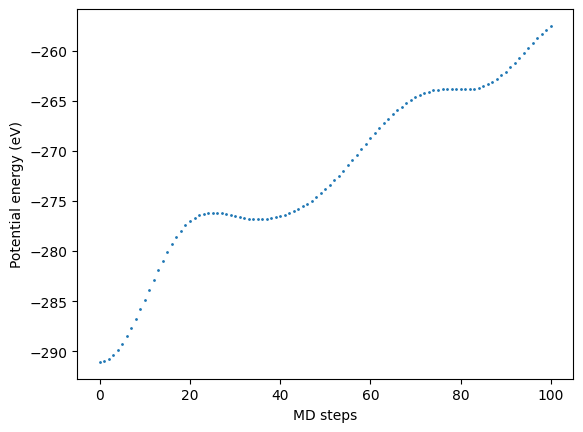

In [35]:
energy1 = np.array(energy_log_1)

plt.scatter(energy1[:,0], energy1[:,1], s=1)
plt.xlabel("MD steps")
plt.ylabel("Potential energy (eV)")

### 停止と再開
* 43回目のMDステップで例外を発生させるextensionを定義します。

In [36]:
class RaiseException(MDExtensionBase):
    def __call__(self, system, integrator):
        if system.current_total_step == 43:
            raise ValueError

* 上の例と同じMDを実行します。MDを再開したい場合、 `MDFeature`のパラメータ`checkpoint_file_name`と`checkpoint_freq`を設定します。 MD featureは、MD systemとintegratorの内部状態を`checkpoint_freq`ステップごとにcheckpointファイルに保存します。
* また、パラメータ`traj_file_name`と`traj_freq`を設定しておき、MDのtrajectoryも保存しておきます。

In [37]:
logger = logging.getLogger("matlantis_features")
logger.setLevel(logging.INFO)

atoms = bulk("Si", cubic=True) * (2,2,2)

nvtbi = NVTBerendsenIntegrator(
    timestep=1.0,
    temperature=2000,
    taut=10.0
    )
mdsys = ASEMDSystem(atoms)
mdsys.init_temperature(2000.0, stationary=True, rng=np.random.RandomState(seed=99))

energy_log_2 = []
extension = EnergyLog(energy_log_2)
exception = RaiseException()

md = MDFeature(
    integrator=nvtbi,
    n_run=100,
    checkpoint_file_name="Si_2000K.ckpt",
    checkpoint_freq=10,
    traj_file_name="Si_2000K.traj",
    traj_freq=10,
    show_progress_bar=True,
    show_logger=True,
    logger_interval=10,
    estimator_fn=estimator_fn,
)
try:
    md_results = md(mdsys, extensions=[(extension, 1), (exception, 1)])
except ValueError as e:
    print("Exception raised ", e)

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /home/jovyan/benchmarks/Si_2000K.traj.
Note: The max disk size of /home/jovyan is about 98G.
steps:     0  energy：-4.55 eV/atom  total energy: -4.29 eV/atom  temperature: 1980.63 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    10  energy：-4.45 eV/atom  total energy: -4.26 eV/atom  temperature: 1438.05 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    20  energy：-4.33 eV/atom  total energy: -4.17 eV/atom  temperature: 1231.73 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    30  energy：-4.32 eV/atom  total energy: -4.10 eV/atom  temperature: 1724.46 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    40  energy：-4.32 eV/atom  total energy: -4.08 eV/atom  temperature: 1888.99 K  volume:  1281 Ang^3  density: 2.330 g/cm^3


Exception raised  


* 予め設定しておいたとおり、43ステップ目にMDが停止しました。checkpointファイル`Si_2000K.ckpt`とtrajectoryファイル`Si_2000K.traj`が左のファイル一覧から確認できます。
* `ASEMDState`を用いてcheckpointファイルからMD systemとintegratorの状態を復元します。
* checkpointファイルは10ステップごとに保存されるため、最後に保存されたのは40ステップ目であることがわかります。

In [38]:
atoms = bulk("Si", cubic=True) * (2,2,2)

nvtbi = NVTBerendsenIntegrator(
    timestep=1.0,
    temperature=2000,
    taut=10.0
    )
mdsys = ASEMDSystem(atoms)

state = ASEMDState.from_file("Si_2000K.ckpt")
state.restore_to(mdsys, nvtbi)

state.system_state["total_step"]

40

* MD featureを先の例と同様に初期化します。注意すべき点として、過去のtrajectoryファイルが上書きされないように`traj_append`を`True`に設定してください。
* さらに、`n_run`を100から60に変更します。MDを40ステップ目から再開するためです。

In [39]:
md = MDFeature(
    integrator=nvtbi,
    n_run=60,
    checkpoint_file_name="Si_2000K.ckpt",
    checkpoint_freq=10,
    traj_file_name="Si_2000K.traj",
    traj_freq=10,
    traj_append=True,
    show_progress_bar=True,
    show_logger=True,
    logger_interval=10,
    estimator_fn=estimator_fn,
)
md_results = md(mdsys, extensions=[(extension, 1)])

  0%|          | 0/60 [00:00<?, ?it/s]

The MD trajectory will be saved at /home/jovyan/benchmarks/Si_2000K.traj.
Note: The max disk size of /home/jovyan is about 98G.
steps:     0  energy：-4.32 eV/atom  total energy: -4.08 eV/atom  temperature: 1888.99 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    10  energy：-4.28 eV/atom  total energy: -4.06 eV/atom  temperature: 1729.13 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    20  energy：-4.20 eV/atom  total energy: -4.01 eV/atom  temperature: 1497.70 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    30  energy：-4.14 eV/atom  total energy: -3.94 eV/atom  temperature: 1521.75 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    40  energy：-4.12 eV/atom  total energy: -3.89 eV/atom  temperature: 1788.41 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    50  energy：-4.09 eV/atom  total energy: -3.87 eV/atom  temperature: 1755.55 K  volume:  1281 Ang^3  density: 2.330 g/cm^3
steps:    60  energy：-4.02 eV/atom  total energy: -3.82 eV/atom  temperature: 15

* MDシミュレーションが40ステップ目に開始し100ステップ目に終了します。
* 計算再開前と後のポテンシャルエネルギーはどちらも `energy_log_2`に格納されています。これをプロットし、通常通り実行したMDのポテンシャルエネルギー`energy_log_1`と比較してみます。
* 両者のポテンシャルエネルギーが一致していることがわかります。このように、MDが途中で意図せず停止しても、上記の手順で計算を再開させることで同じ結果を得ることが可能です。

Text(0, 0.5, 'Potential energy (eV)')

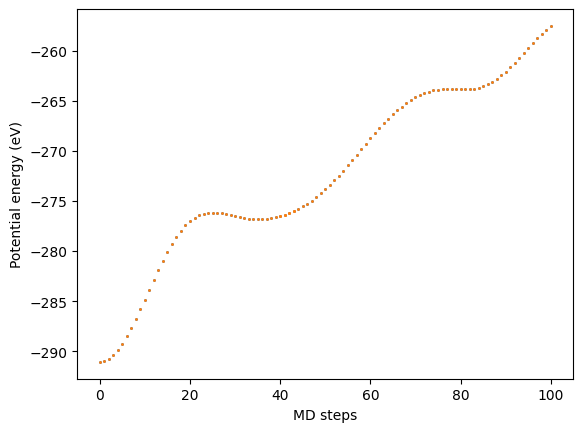

In [40]:
energy2 = np.array(energy_log_2)

plt.scatter(energy1[:,0], energy1[:,1], s=1)
plt.scatter(energy2[:,0], energy2[:,1], s=1)

plt.xlabel("MD steps")
plt.ylabel("Potential energy (eV)")

<a id='advanced_6'></a>
## 6. MD integratorを構築する方法

matlantis-featuresの`integrators`にはすでにいくつかのASE Intergratorのラッパーが実装されていますが、 次の例では、必要なインテグレータを自由に定義できるよう、ASEのMDメソッドからmatlantis-featuresで`intergretor`クラスを作成する方法を示します。

ここでは、例としてASEの`Inhomogeneous_NPTBerendsen`を使用します。類似の手法としてNPTBerendsenが存在しますが、NPTBerendsenでは格子の形状（格子長の比率 a：b：c と3つの軸の角度 $\alpha$, $\beta$, $\gamma$）は変更されないのに対し、Inhomogeneous NPTBerendsenでは格子長の比率 a:b:cが変更されます。

In [41]:
from typing import List

import numpy as np
from ase import Atoms, units
from ase.build import bulk
from ase.optimize.optimize import Dynamics
from ase.md.nptberendsen import Inhomogeneous_NPTBerendsen

from matlantis_features.features.md.ase_integrators import ASEIntegrator
from matlantis_features.features.md import NPTIntegrator, ASEMDSystem, MDFeature, MDExtensionBase, NPTBerendsenIntegrator


`InhomogeneousNPTBerendsenIntegrator`を作成します。
* まず、新しいintegratorを作成する際には`ASEIntegrator`を継承する必要があります。
* 重要な点として、`InhomogeneousNPTBerendsenIntegrator`の初期化関数`__init__`で`_get_dyn`関数を必ず定義してください。 `_get_dyn`関数は、入力パラメーターとしてASEの`Atoms`オブジェクトをとり、ASEの`Inhomogeneous_NPTBerendsen`オブジェクトを出力します。

In [42]:
class InhomogeneousNPTBerendsenIntegrator(ASEIntegrator):
    def __init__(
        self,
        timestep: float,
        temperature: float,
        pressure: float,
        taut: float = 500,
        taup: float = 1000,
        compressibility: float = 67.2,
        fixcm: bool = True,
        mask: List[bool] = [True, True, True]
    ):
        def _get_dyn(atoms: Atoms) -> Dynamics:
            return Inhomogeneous_NPTBerendsen(
                atoms,
                timestep=self.timestep * units.fs,
                temperature_K=self.temperature,
                pressure_au=self.pressure,
                taut=self.taut * units.fs,
                taup=self.taup * units.fs,
                compressibility_au=self.compressibility,
                fixcm=self.fixcm,
                mask=self.mask
            )

        super().__init__(get_dynamics_fn=_get_dyn, timestep=timestep)
        self.temperature = temperature
        self.pressure = pressure
        self.taut = taut
        self.taup = taup
        self.compressibility = compressibility
        self.fixcm = fixcm
        self.mask = mask


`InhomogeneousNPTBerendsenIntegrator`をテストしてみます。 まず、MDの実行中に格子形状の情報を出力するための`extension`を定義します。

In [43]:
class PrintCellShape(MDExtensionBase):
    def __init__(self, cell_log=None):
        self.cell_log = cell_log
    def __call__(self, system, integrator) -> None:
        cell_par = system.ase_atoms.cell.cellpar()
        istep = system.current_total_step
        print(f"Dyn step {istep:4d} a {cell_par[0]:3.5f} b {cell_par[1]:3.5f} c {cell_par[2]:3.5f} alpha {cell_par[3]:3.2f} beta {cell_par[4]:3.2f} gamma {cell_par[5]:3.2f} ")
        if self.cell_log is not None:
            self.cell_log.append(cell_par)


MDの実行を開始します。 InhomogeneousNPTBerendsenIntegratorを使用すると、格子の3つの軸の長さの変化が不均一であることがわかります。

興味があれば、NPTBerendsenIntegratorを使用して同じタスクを再実行し結果を比較してみましょう。 軸 $a$ $b$ $c$ の変化は一様であることが確認できます。

In [44]:
integrator = InhomogeneousNPTBerendsenIntegrator(
    timestep=1.0,
    temperature=300,
    pressure=101325 * units.Pascal,
)
# integrator = NPTBerendsenIntegrator(
#     timestep=1.0,
#     temperature=300,
#     pressure=101325 * units.Pascal,
# )

system = ASEMDSystem(bulk("Si", cubic=True)*(2,2,2))
system.init_temperature(300.0, stationary=True, rng=np.random.RandomState(seed=999))

md = MDFeature(integrator=integrator, n_run=100, show_progress_bar=True, show_logger=True, logger_interval=100, estimator_fn=estimator_fn)
md_results = md(system, extensions=[(PrintCellShape(), 10)])

  0%|          | 0/100 [00:00<?, ?it/s]

The MD trajectory will be saved at /tmp/matlantis_cwxtxdq7/tmpu1eb388y.traj.
Note: The max disk size of / is about 30G.
Note: The MD trajectory is saved in a temporary directory, which will be automatically deleted later.
steps:     0  energy：-4.55 eV/atom  total energy: -4.51 eV/atom  temperature: 278.85 K  volume:  1281 Ang^3  density: 2.330 g/cm^3


Dyn step    0 a 10.86000 b 10.86000 c 10.86000 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   10 a 10.88866 b 10.88822 c 10.88776 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   20 a 10.90881 b 10.90871 c 10.90854 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   30 a 10.92116 b 10.92130 c 10.92216 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   40 a 10.92801 b 10.92777 c 10.92945 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   50 a 10.93316 b 10.93282 c 10.93417 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   60 a 10.93710 b 10.93773 c 10.93750 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   70 a 10.93880 b 10.94043 c 10.93890 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   80 a 10.94010 b 10.94138 c 10.94014 alpha 90.00 beta 90.00 gamma 90.00 
Dyn step   90 a 10.94292 b 10.94339 c 10.94325 alpha 90.00 beta 90.00 gamma 90.00 


steps:   100  energy：-4.53 eV/atom  total energy: -4.51 eV/atom  temperature: 171.26 K  volume:  1311 Ang^3  density: 2.276 g/cm^3


Dyn step  100 a 10.94517 b 10.94594 c 10.94596 alpha 90.00 beta 90.00 gamma 90.00 
